In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import random
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import confusion_matrix
from sklearn.metrics import accuracy_score
from tqdm import tqdm_notebook as tqdm
from sklearn.model_selection import cross_val_score
from recourse.builder import RecourseBuilder
from recourse.builder import ActionSet
from lime.lime_tabular import LimeTabularExplainer

from scipy.stats import wasserstein_distance


In [2]:
np.random.seed(0)
random.seed(0)

In [3]:
def gen_data(means, covs, clf, points=2500):
    data = np.random.multivariate_normal(means, covs, points)
    data = pd.DataFrame(data, columns=['X0', 'X1'])
    data['target'] = clf(data['X0'], data['X1'])
    data['target'] = data['target'].astype(float)
    return data

In [4]:
def gen_recourses(data, model, lime=False):
    population = data.copy()
    population['PRED'] = model.predict(population.to_numpy())
    if lime:
        explainer = LimeTabularExplainer(data.to_numpy(), feature_names=data.columns, class_names=np.unique(population['PRED']), discretize_continuous=False)
    population = population[population['PRED'] == 0]
    population = population.drop(columns=['PRED'])
    
    no_recourse = []
    recourses = pd.DataFrame(columns=population.columns)
    for index, row in tqdm(population.iterrows(), total=population.shape[0]):
        row = row.values.reshape(1,-1)
        if lime:
            clf = explainer.explain_instance(row.flatten(), predict_fn=model.predict_proba)#, labels=[0,1])
            coefficients = {feat: coeff for (feat, coeff) in clf.as_list()}
            coefficients = np.array([coefficients.get(feat, 0) for feat in population.columns])
            intercept = clf.intercept[1] # - clf_base2.intercept[1]
        else:
            coefficients = np.array(model.coef_).flatten()
            intercept = model.intercept_[0]
        rb = RecourseBuilder(
              optimizer="cplex",
              coefficients=np.round(coefficients, decimals=4),
              intercept=np.round(intercept, decimals=4),
              action_set=ActionSet(X=data),
              x=row
        )
        rb = rb.fit()
        if not rb['feasible']:
            no_recourse.append(index)
            continue
        new_row = row + rb['actions']
        if model.predict(new_row)[0] == 0:
            no_recourse.append(index)
            continue
        recourses.loc[index] = new_row.flatten()
    return recourses, no_recourse

In [5]:
means = [0,0]
covs = [[1,0],[0,1]]
def clf(X0, X1):
    return X0 + X1 > 0
def get_clf(alpha):
    return lambda X0, X1: X0 + alpha*X1 > 0

In [6]:
def run_single(means1, covs1, means2, covs2, clf1, clf2):
    D1 = gen_data(means1, covs1, clf1)
    D2 = gen_data(means2, covs1, clf2)

    M1 = LogisticRegression(random_state=0, solver='liblinear')
    M1.fit(D1[['X0', 'X1']], D1['target'])

    CF1, ncf1 = gen_recourses(D1[['X0', 'X1']], M1)

    M2 = LogisticRegression(random_state=0, solver='liblinear')
    M2.fit(D2[['X0', 'X1']], D2['target'])

    CF1['target'] = clf(CF1['X0'], CF1['X1'])
    CF1['target'] = CF1['target'].astype(float)
    CF1['M1_pred'] = M1.predict(CF1[['X0', 'X1']])
    CF1['M2_pred'] = M2.predict(CF1[['X0', 'X1']])

    invpct = 100*(1-np.mean(CF1['M2_pred']))
    # print('Invalidation is', invpct, '%')
    M1_acc = cross_val_score(M1, D1[['X0', 'X1']], D1['target'], cv=10).mean()
    # print('M1 cross val acc', M1_acc)
    M2_acc = cross_val_score(M2, D2[['X0', 'X1']], D2['target'], cv=10).mean()
    # print('M2 cross val acc', M2_acc)
    return invpct, M1_acc, M2_acc, wasserstein_distance(D1['X0'], D2['X0'])

In [7]:
def runall(alphas):
    inv, M1accs, M2accs, shifts = [], [], [], []
    for alpha in tqdm(alphas):
        invpct, m1, m2, shift = run_single(means, covs, means, covs, clf, get_clf(alpha))
        inv.append(invpct)
        M1accs.append(m1)
        M2accs.append(m2)
        shifts.append(shift)
    return inv, M1accs, M2accs, shifts

In [8]:
def gen_data(means, covs, clf, points=2000):
    data = np.random.multivariate_normal(means, covs, points)
    data = pd.DataFrame(data, columns=['X0', 'X1'])
    data['target'] = clf(data['X0'], data['X1'])
    data['target'] = data['target'].astype(float)
    return data

In [9]:
alphas3 = [i/100 for i in range(60,85,10)]
alphas3 += [i/100 for i in range(85,95,2)]
alphas3 += [i/100 for i in range(95,98,1)]
alphas3 += [i/1000 for i in range(980,1021,5)]
alphas3 += [i/100 for i in range(103,105,1)]
alphas3 += [i/100 for i in range(105,116,2)]
alphas3 += [i/100 for i in range(120,151,10)]

100*(np.array(alphas3)-1)

array([-40. , -30. , -20. , -15. , -13. , -11. ,  -9. ,  -7. ,  -5. ,
        -4. ,  -3. ,  -2. ,  -1.5,  -1. ,  -0.5,   0. ,   0.5,   1. ,
         1.5,   2. ,   3. ,   4. ,   5. ,   7. ,   9. ,  11. ,  13. ,
        15. ,  20. ,  30. ,  40. ,  50. ])

In [10]:
inv3, M1accs3, M2accs3, shifts = runall(alphas3)

<Figure size 1080x720 with 0 Axes>

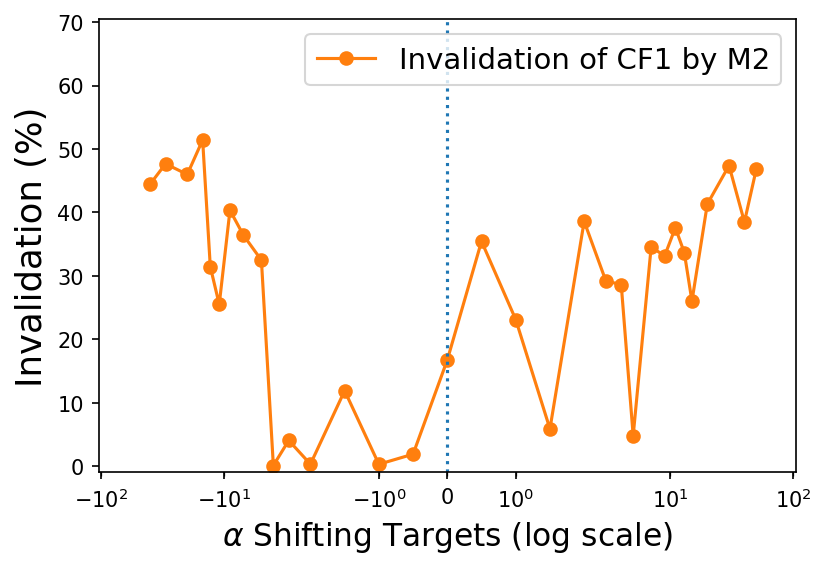

In [19]:
t = 100*(np.array(alphas3)-1)
data1 = inv3
# data2 = 100*np.array(M1accs3)+np.random.random(len(alphas3))
# data3 = 100*np.array(M2accs3)+np.random.random(len(alphas3))
data2 = 100*np.array(M1accs3)
data3 = 100*np.array(M2accs3)

plt.figure(dpi=180)
fig, ax1 = plt.subplots()
fig.set_dpi(150)

color = 'C1'
ax1.set_xlabel(r'$\alpha$ Shifting Targets (log scale)', fontsize=15)
ax1.set_ylabel('Invalidation (%)', fontsize=17)#, color='C1')
ax1.plot(t, data1, color=color, label='Invalidation of CF1 by M2', marker='o')
ax1.tick_params(axis='y')#, labelcolor='C1')
ax1.set_ylim(-1, 19+max(data1))
ax1.set_xlim(-105, 105)
ax1.axvline(0, linestyle=':')
# ax1.axvline(0, color='C3', linestyle=':', label='No Shift')
# ax1.legend(loc=3)
ax1.legend(fontsize=14)
ax1.set_xscale('symlog')

# ax2 = ax1.twinx()
# color = 'C0'
# ax2.set_ylabel('10-Fold CrossVal Accuracy (%)', color='C0')
# ax2.plot(t+0.01, data2, label='M1 acc.', color='C0', marker='1', zorder=2, alpha=0.5)
# ax2.plot(t-0.01, data3, label='M2 acc.', color='C2', marker='2', zorder=1, alpha=0.5)
# # ax2.scatter(t-0.01, data3, label='M2 acc.', color='red', marker='.')
# ax2.tick_params(axis='y', labelcolor='C2')
# ax2.set_ylim(-1, 104)
# ax2.legend(loc=4)

# plt.title('Invalidation vs Distribution Shifts')
plt.show()


In [12]:
print(t)
print(data1)
print(data2)
print(data3)

[-40.  -30.  -20.  -15.  -13.  -11.   -9.   -7.   -5.   -4.   -3.   -2.
  -1.5  -1.   -0.5   0.    0.5   1.    1.5   2.    3.    4.    5.    7.
   9.   11.   13.   15.   20.   30.   40.   50. ]
[44.466019417475735, 47.66990291262137, 45.98984771573604, 51.42276422764227, 31.450827653359305, 25.5, 40.3420523138833, 36.417910447761194, 32.47687564234327, 0.09920634920634885, 4.055390702274975, 0.30674846625766694, 11.895161290322577, 0.29615004935834577, 1.8887722980062915, 16.732673267326735, 35.446985446985444, 23.11661506707946, 5.876393110435663, 38.59832635983263, 29.20892494929006, 28.612440191387556, 4.7952047952048, 34.56032719836401, 33.14393939393939, 37.58389261744966, 33.673469387755105, 26.01547388781431, 41.32553606237816, 47.39429695181907, 38.49167482859941, 46.875]
[99.70024876 99.649995   99.85074627 99.6        99.70074627 99.70049251
 99.74924373 99.55024376 99.75       99.749995   99.64949749 99.8
 99.64924373 99.9        99.49949749 99.6499975  99.79924623 99.600990